# 12.10 Adam

In the discussions leading up to this section we encountered a number of techniques for efficient optimization. Let’s recap them in detail here:

 - We saw that Section 12.4 is more effective than Gradient Descent when solving optimization problems, e.g., due to its inherent resilience to redundant data.
 - We saw that Section 12.5 affords significant additional efficiency arising from vectorization, using larger sets of observations in one minibatch. This is the key to efficient multimachine, multi-GPU and overall parallel processing.
 - Section 12.6 added a mechanism for aggregating a history of past gradients to accelerate convergence.
 - Section 12.7 used per-coordinate scaling to allow for a computationally efficient preconditioner.
 - Section 12.8 decoupled per-coordinate scaling from a learning rate adjustment.

Adam (Kingma and Ba, 2014) combines all these techniques into one efficient learning algorithm. As expected, this is an algorithm that has become rather popular as one of the more robust and effective optimization algorithms to use in deep learning. It is not without issues, though. In particular, (Reddi et al., 2019) show that there are situations where Adam can diverge due to poor variance control. In a follow-up work Zaheer et al. (2018) proposed a hotfix to Adam, called Yogi which addresses these issues. More on this later. For now let’s review the Adam algorithm.

## 12.10.1 The Algorithm

$$

\mathbf{v}_t \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g_t} \\
\mathbf{s}_t \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g_t}^2

$$

Here β1 and β2 are nonnegative weighting parameters. Common choices for them are β1 = 0.9 and β2 = 0.999. That is, the variance estimate moves much more slowly than the momentum term.

Correspondingly, the normalized state variables are given by

$$

\hat{\mathbf{v_t}} = \cfrac{\mathbf{v_t}}{1 - {\beta_1}^t} \\
\hat{\mathbf{s_t}} = \cfrac{\mathbf{v_t}}{1 - {\beta_2}^t}

$$

And then, we rescale the gradient:

$$

\mathbf{g_t}' = \cfrac{\eta \hat{v_t}}{\sqrt{\hat{s}_t} + \epsilon}

$$

We now obtain the update form:

$$

\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g_t}'

$$

## 12.10.2 Implementation

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
            + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

loss: 0.243, 0.026 sec/epoch


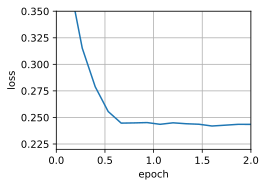

In [2]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
{'lr': 0.01, 't': 1}, data_iter, feature_dim);

loss: 0.247, 0.013 sec/epoch


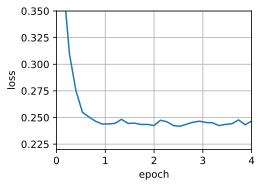

In [3]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

### 12.10.3 Yogi

One of the problems of Adam is that it can fail to converge even in convex settings when the second moment estimate in st blows up. As a fix Zaheer et al. (2018) proposed a refined update (and initialization) for st . To understand what’s going on, let’s rewrite the Adam update as follows:

$$

\mathbf{s}_t \leftarrow \mathbf{s_{t-1}} + (1 - \beta_2)(\mathbf{g_t}^2 - s_{t-1})

$$

Now the magnitude of the update no longer dependes on the amount of deviation. This yields the Yogi updates:


$$

\mathbf{s}_t \leftarrow \mathbf{s_{t-1}} + (1 - \beta_2) \mathbf{g_t}^2 \odot sgn(\mathbf{g_t}^2 - \mathbf{s}_{t-1})

$$

loss: 0.242, 0.018 sec/epoch


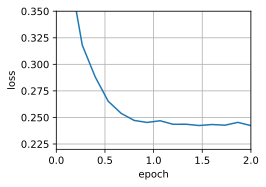

In [4]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
            + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
{'lr': 0.01, 't': 1}, data_iter, feature_dim);